In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import h5py
import matplotlib.pyplot as plt
import tensorflow as tf

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

import numpy as np
import time
import os
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.15.0


In [2]:
# open hdf5 file and extract datasets
h5f = h5py.File('data/SVHN_gray.h5','r')
X_train = h5f['train_dataset'][:]
y_train = h5f['train_labels'][:]
X_val = h5f['validation_dataset'][:]
y_val = h5f['validation_labels'][:]
X_test = h5f['test_dataset'][:]
y_test = h5f['test_labels'][:]
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (228254, 32, 32, 1) (228254, 5)
Validation set (7500, 32, 32, 1) (7500, 5)
Test set (13068, 32, 32, 1) (13068, 5)


In [3]:
# data dimensions
_, img_height, img_width, num_channels = X_train.shape

# label information
num_digits, num_labels = y_train.shape[1], len(np.unique(y_train))

In [4]:
X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

print('Training set', X_train.shape, y_train.shape)

Training set (235754, 32, 32, 1) (235754, 5)


In [5]:
from sklearn.utils import shuffle
# shuffle data
X_train, y_train = shuffle(X_train, y_train)

In [6]:
# function for mean subtraction
def subtract_mean(a):
    for i in range(a.shape[0]):
        a[i] -= a[i].mean()
    return a

X_train = subtract_mean(X_train)
X_test = subtract_mean(X_test)
X_val = subtract_mean(X_val)

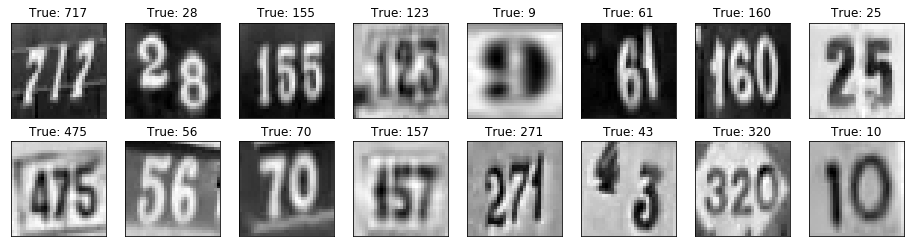

In [7]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    # random select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    for i, ax in zip(rs, axes.flat): 
        # string with actual number
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            # string with predicted number
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number) 
        ax.imshow(images[i,:,:,0], cmap='binary')
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])
        
# plot
plot_images(X_train, 2, 8, y_train)

In [8]:
# initialize weights
def init_conv_weights(shape, name):
    return tf.get_variable(name, shape, initializer= tf.contrib.layers.xavier_initializer_conv2d())# tf.keras.initializers.lecun_normal(seed=None)

def init_fc_weights(shape, name):
    return tf.get_variable(name, shape, initializer= tf.contrib.layers.xavier_initializer())#tf.keras.initializers.lecun_normal(seed=None))

def init_biases(shape):
    return tf.Variable(tf.constant(0.0, shape=shape))

In [9]:
def conv_layer(input_tensor,    # input or from previous layer
                filter_size,    # width and height of each filter
                in_channels,    # #of channels in previous layer
                num_filters,    # #of filters
                layer_name,     # layer name
                pooling):       # max-pooling option
    
    # layer name scopes for better graph visualization
    with tf.name_scope(layer_name):
        # shape of filter-weights for convolution
        shape = [filter_size, filter_size, in_channels, num_filters]
        # weights and biases
        weights = init_conv_weights(shape, layer_name + '/weights')
        biases = init_biases([num_filters])
        tf.summary.histogram(layer_name + '/weights', weights)
        # tensorFlow operation for convolution, with S=1 and zero padding
        activations = tf.nn.conv2d(input_tensor, weights, [1, 1, 1, 1], 'SAME') + biases
        # ReLU
        activations = tf.nn.relu(activations)
        if pooling:
            # Create a pooling layer with F=2, S=1 and zero padding
            activations = tf.nn.max_pool(activations, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
        # Return the resulting layer
        return activations

In [10]:
# function for transforming a 4D tensor to 2D
def flatten_tensor(input_tensor):
    # find shape of the input_tensor.
    input_tensor_shape = input_tensor.get_shape()
    # find volume of input tensor
    num_activations = input_tensor_shape[1:4].num_elements()
    # reshape input tensor to 2D
    input_tensor_flat = tf.reshape(input_tensor, [-1, num_activations])
    # return flattened input_tensor and #of activations
    return input_tensor_flat, num_activations

In [11]:
def fc_layer(input_tensor,  # previous layer,         
             input_dim,     # #ofinputs from prev. layer
             output_dim,    # #of outputs
             layer_name,    # layer name
             relu=False):   

    # layer name scopes for graph visualization
    with tf.name_scope(layer_name):
        # new weights and biases.
        weights = init_fc_weights([input_dim, output_dim], layer_name + '/weights')
        biases = init_biases([output_dim])
        # histogram summaries for weights
        tf.summary.histogram(layer_name + '/weights', weights)
        # layer activations
        activations = tf.matmul(input_tensor, weights) + biases
        # ReLU
        if relu:
            activations = tf.nn.relu(activations)
        return activations

In [12]:
# conv block 1
filter_size1 = filter_size2 = 5          
num_filters1 = num_filters2 = 32        

# conv block 2
filter_size3 = filter_size4 = 5          
num_filters3 = num_filters4 = 64

# conv block 3
filter_size5 = filter_size6 = filter_size7 = 5          
num_filters5 = num_filters6 = num_filters7 = 128  

# FC fully-connected layers
fc1_size = fc2_size = 256

In [13]:
with tf.name_scope("input"):
    
    # TF placeholders for feeding input images
    x = tf.placeholder(tf.float32, shape=(None, img_height, img_width, num_channels), name='x')
    y_ = tf.placeholder(tf.int64, shape=[None, num_digits], name='y_')

with tf.name_scope("dropout"):
    # dropout to input layer
    p_keep_1 = tf.placeholder(tf.float32)
    tf.summary.scalar('input_keep_probability', p_keep_1)
    # dropout after the pooling layers
    p_keep_2 = tf.placeholder(tf.float32)
    tf.summary.scalar('conv_keep_probability', p_keep_2)
    # dropout rate using between the fully-connected layers
    p_keep_3 = tf.placeholder(tf.float32)
    tf.summary.scalar('fc_keep_probability', p_keep_3)

In [14]:
# dropout to the input layer
drop_input = tf.nn.dropout(x, p_keep_1) 
# conv block 1
conv_1 = conv_layer(drop_input, filter_size1, num_channels, num_filters1, "conv_1", pooling=False)
conv_2 = conv_layer(conv_1, filter_size2, num_filters1, num_filters2, "conv_2", pooling=True)
drop_block1 = tf.nn.dropout(conv_2, p_keep_2) # Dropout
# conv block 2
conv_3 = conv_layer(conv_2, filter_size3, num_filters2, num_filters3, "conv_3", pooling=False)
conv_4 = conv_layer(conv_3, filter_size4, num_filters3, num_filters4, "conv_4", pooling=True)
drop_block2 = tf.nn.dropout(conv_4, p_keep_2) # Dropout
# conv block 3
conv_5 = conv_layer(drop_block2, filter_size5, num_filters4, num_filters5, "conv_5", pooling=False)
conv_6 = conv_layer(conv_5, filter_size6, num_filters5, num_filters6, "conv_6", pooling=False)
conv_7 = conv_layer(conv_6, filter_size7, num_filters6, num_filters7, "conv_7", pooling=True)
flat_tensor, num_activations = flatten_tensor(tf.nn.dropout(conv_7, p_keep_3)) # Dropout
# FC1
fc_1 = fc_layer(flat_tensor, num_activations, fc1_size, 'fc_1', relu=True)
drop_fc2 = tf.nn.dropout(fc_1, p_keep_3) # Dropout
# FC2
fc_2 = fc_layer(drop_fc2, fc1_size, fc2_size, 'fc_2', relu=True)
# for each digit paralell softmax layers
logits_1 = fc_layer(fc_2, fc2_size, num_labels, 'softmax1')
logits_2 = fc_layer(fc_2, fc2_size, num_labels, 'softmax2')
logits_3 = fc_layer(fc_2, fc2_size, num_labels, 'softmax3')
logits_4 = fc_layer(fc_2, fc2_size, num_labels, 'softmax4')
logits_5 = fc_layer(fc_2, fc2_size, num_labels, 'softmax5')

y_pred = tf.stack([logits_1, logits_2, logits_3, logits_4, logits_5])

# class-number is index of largest element
y_pred_cls = tf.transpose(tf.argmax(y_pred, dimension=2))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use the `axis` argument instead


In [15]:
with tf.name_scope('loss'):
    
    # loss for individual digit in the sequence
    loss1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits_1, labels = y_[:, 0]))
    loss2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits_2, labels = y_[:, 1]))
    loss3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits_3, labels = y_[:, 2]))
    loss4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits_4, labels = y_[:, 3]))
    loss5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits_5, labels = y_[:, 4]))
    # total loss for all predictions
    loss = loss1 + loss2 + loss3 + loss4 + loss5
    tf.summary.scalar('loss', loss)

In [16]:
with tf.name_scope('optimizer'):
    # global step required to compute the decayed learning rate
    global_step = tf.Variable(0, trainable=False)
    # apply exponential decay to the learning rate
    learning_rate = tf.train.exponential_decay(1e-3, global_step, 7500, 0.5, staircase=True)
    tf.summary.scalar('learning_rate', learning_rate)
    # construct a new Adam optimizer
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, global_step=global_step)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
with tf.name_scope("accuracy"):
    # check if predicted class equals the true class of each image
    correct_prediction = tf.reduce_min(tf.cast(tf.equal(y_pred_cls, y_), tf.float32), 1)
    # cast predictions to float and calculate mean
    accuracy = tf.reduce_mean(correct_prediction) * 100.0
    # add scalar summary for accuracy tensor
    tf.summary.scalar('accuracy', accuracy)

In [18]:
session = tf.Session()

In [19]:
saver = tf.train.Saver()
save_path = os.path.join('checkpoints/', 'svhn_multi_v5')
# find latest checkpoint
try:
    print("Restoring last checkpoint ...")
    # find the filename of latest saved checkpoint file
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_path)
    # load its data
    saver.restore(session, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
# if the above fails initialize all the variables
except:
    print("Failed to restore checkpoint - initializing variables")
    session.run(tf.global_variables_initializer())

Restoring last checkpoint ...
INFO:tensorflow:Restoring parameters from checkpoints/svhn_multi_v5\svhn_multi_v5-12600
Restored checkpoint from: checkpoints/svhn_multi_v5\svhn_multi_v5-12600


In [20]:
LOG_DIR = 'logs/svhn_multi_v5/'
# merge all summaries and write them out to /logs/svhn_multi_v5
merged = tf.summary.merge_all()

# pass graph to the writer to display it in tensorboard
train_writer = tf.summary.FileWriter(LOG_DIR + '/train', session.graph)
validation_writer = tf.summary.FileWriter(LOG_DIR + '/validation')

In [21]:
batch_size = 64
# dropout applied to the input layer
d1 = 0.9
# dropout applied between conv layers
d2 = 0.75
# dropout applied to fully-connected layers
d3 = 0.5

In [22]:
# tensorFlow feed_dict mapping data onto the placeholders
def feed_dict(step=0):
    # Calculate the offset
    offset = (step * batch_size) % (y_train.shape[0] - batch_size)
    # get batch data
    xs, ys = X_train[offset:offset + batch_size], y_train[offset:offset+batch_size]
    return {x: xs, y_: ys, p_keep_1: d1, p_keep_2: d2, p_keep_3: d3}

def evaluate_batch(test, batch_size):
    # store cumulative accuracy over all batches
    cumulative_accuracy = 0.0
    # get number of images
    n_images = y_test.shape[0] if test else y_val.shape[0]
    # Numer of batches needed to evaluate all images
    n_batches = n_images // batch_size + 1
    # iterate over all batches
    for i in range(n_batches):
        # calculate offset
        offset = i * batch_size
        if test:
            # get batch from test set
            xs, ys = X_test[offset:offset+batch_size], y_test[offset:offset+batch_size]
        else:
            # get batch from validation set
            xs, ys = X_val[offset:offset+batch_size], y_val[offset:offset+batch_size]
        cumulative_accuracy += session.run(accuracy, {x: xs, y_: ys, p_keep_1: 1., p_keep_2: 1., p_keep_3: 1.})                                   
    # return average accuracy over all the batches
    return cumulative_accuracy / (0.0 + n_batches)

In [23]:
def optimize(num_iterations, display_step):
    start_time = time.time()
    for step in range(num_iterations):
        # run optimizer using this batch of training data.
        summary, i, _ = session.run([merged, global_step, optimizer,accuracy,loss], feed_dict(step))
        train_writer.add_summary(summary, i)
        # print status every display_step iteration
        if (i % display_step == 0) or (step == num_iterations - 1):   
            # calculate minibatch accuracy
            batch_acc = session.run(accuracy, feed_dict=feed_dict(step))
            print("Minibatch accuracy at step %d: %.4f" % (i, batch_acc))
            # calculate accuracy on the validation-set
            valid_acc = evaluate_batch(test=False, batch_size=512)
            print("Validation accuracy at step %s: %.4f" % (i, valid_acc))
    # total training time
    run_time = time.time() - start_time
    print("\nTime usage: " + str(timedelta(seconds=int(round(run_time)))))
    # testset accuracy
    test_acc = evaluate_batch(test=True, batch_size=512)
    print("Test accuracy: %.4f" % test_acc)
    # save variables of TensorFlow graph
    saver.save(session, save_path=save_path, global_step=global_step)
    print('Model saved in file: {}'.format(save_path))
    tf.train.write_graph(session.graph_def, save_path, 'savegraph.pbtxt')

In [25]:
optimize(num_iterations=100, display_step=100)

Minibatch accuracy at step 12800: 85.9375
Validation accuracy at step 12800: 84.7361

Time usage: 0:00:45
Test accuracy: 83.8064
Model saved in file: checkpoints/svhn_multi_v5


In [ ]:
# correct classified images
correct = np.array([(a==b).all() for a, b in zip(test_pred, y_test)])

# select correctly classified images
images = X_test[correct]
cls_true = y_test[correct]
cls_pred = test_pred[correct]

# plot
plot_images(images, 4, 4, cls_true, cls_pred);

In [ ]:
# invert to get incorrectly classified images
incorrect = np.invert(correct)

# select the incorrectly classified images
images = X_test[incorrect]
cls_true = y_test[incorrect]
cls_pred = test_pred[incorrect]

# plot
plot_images(images, 4, 4, cls_true, cls_pred);